# Brazilian E-Commerce Public Dataset by Olist
Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by  . We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

### Context
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

### Data Schema
The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:
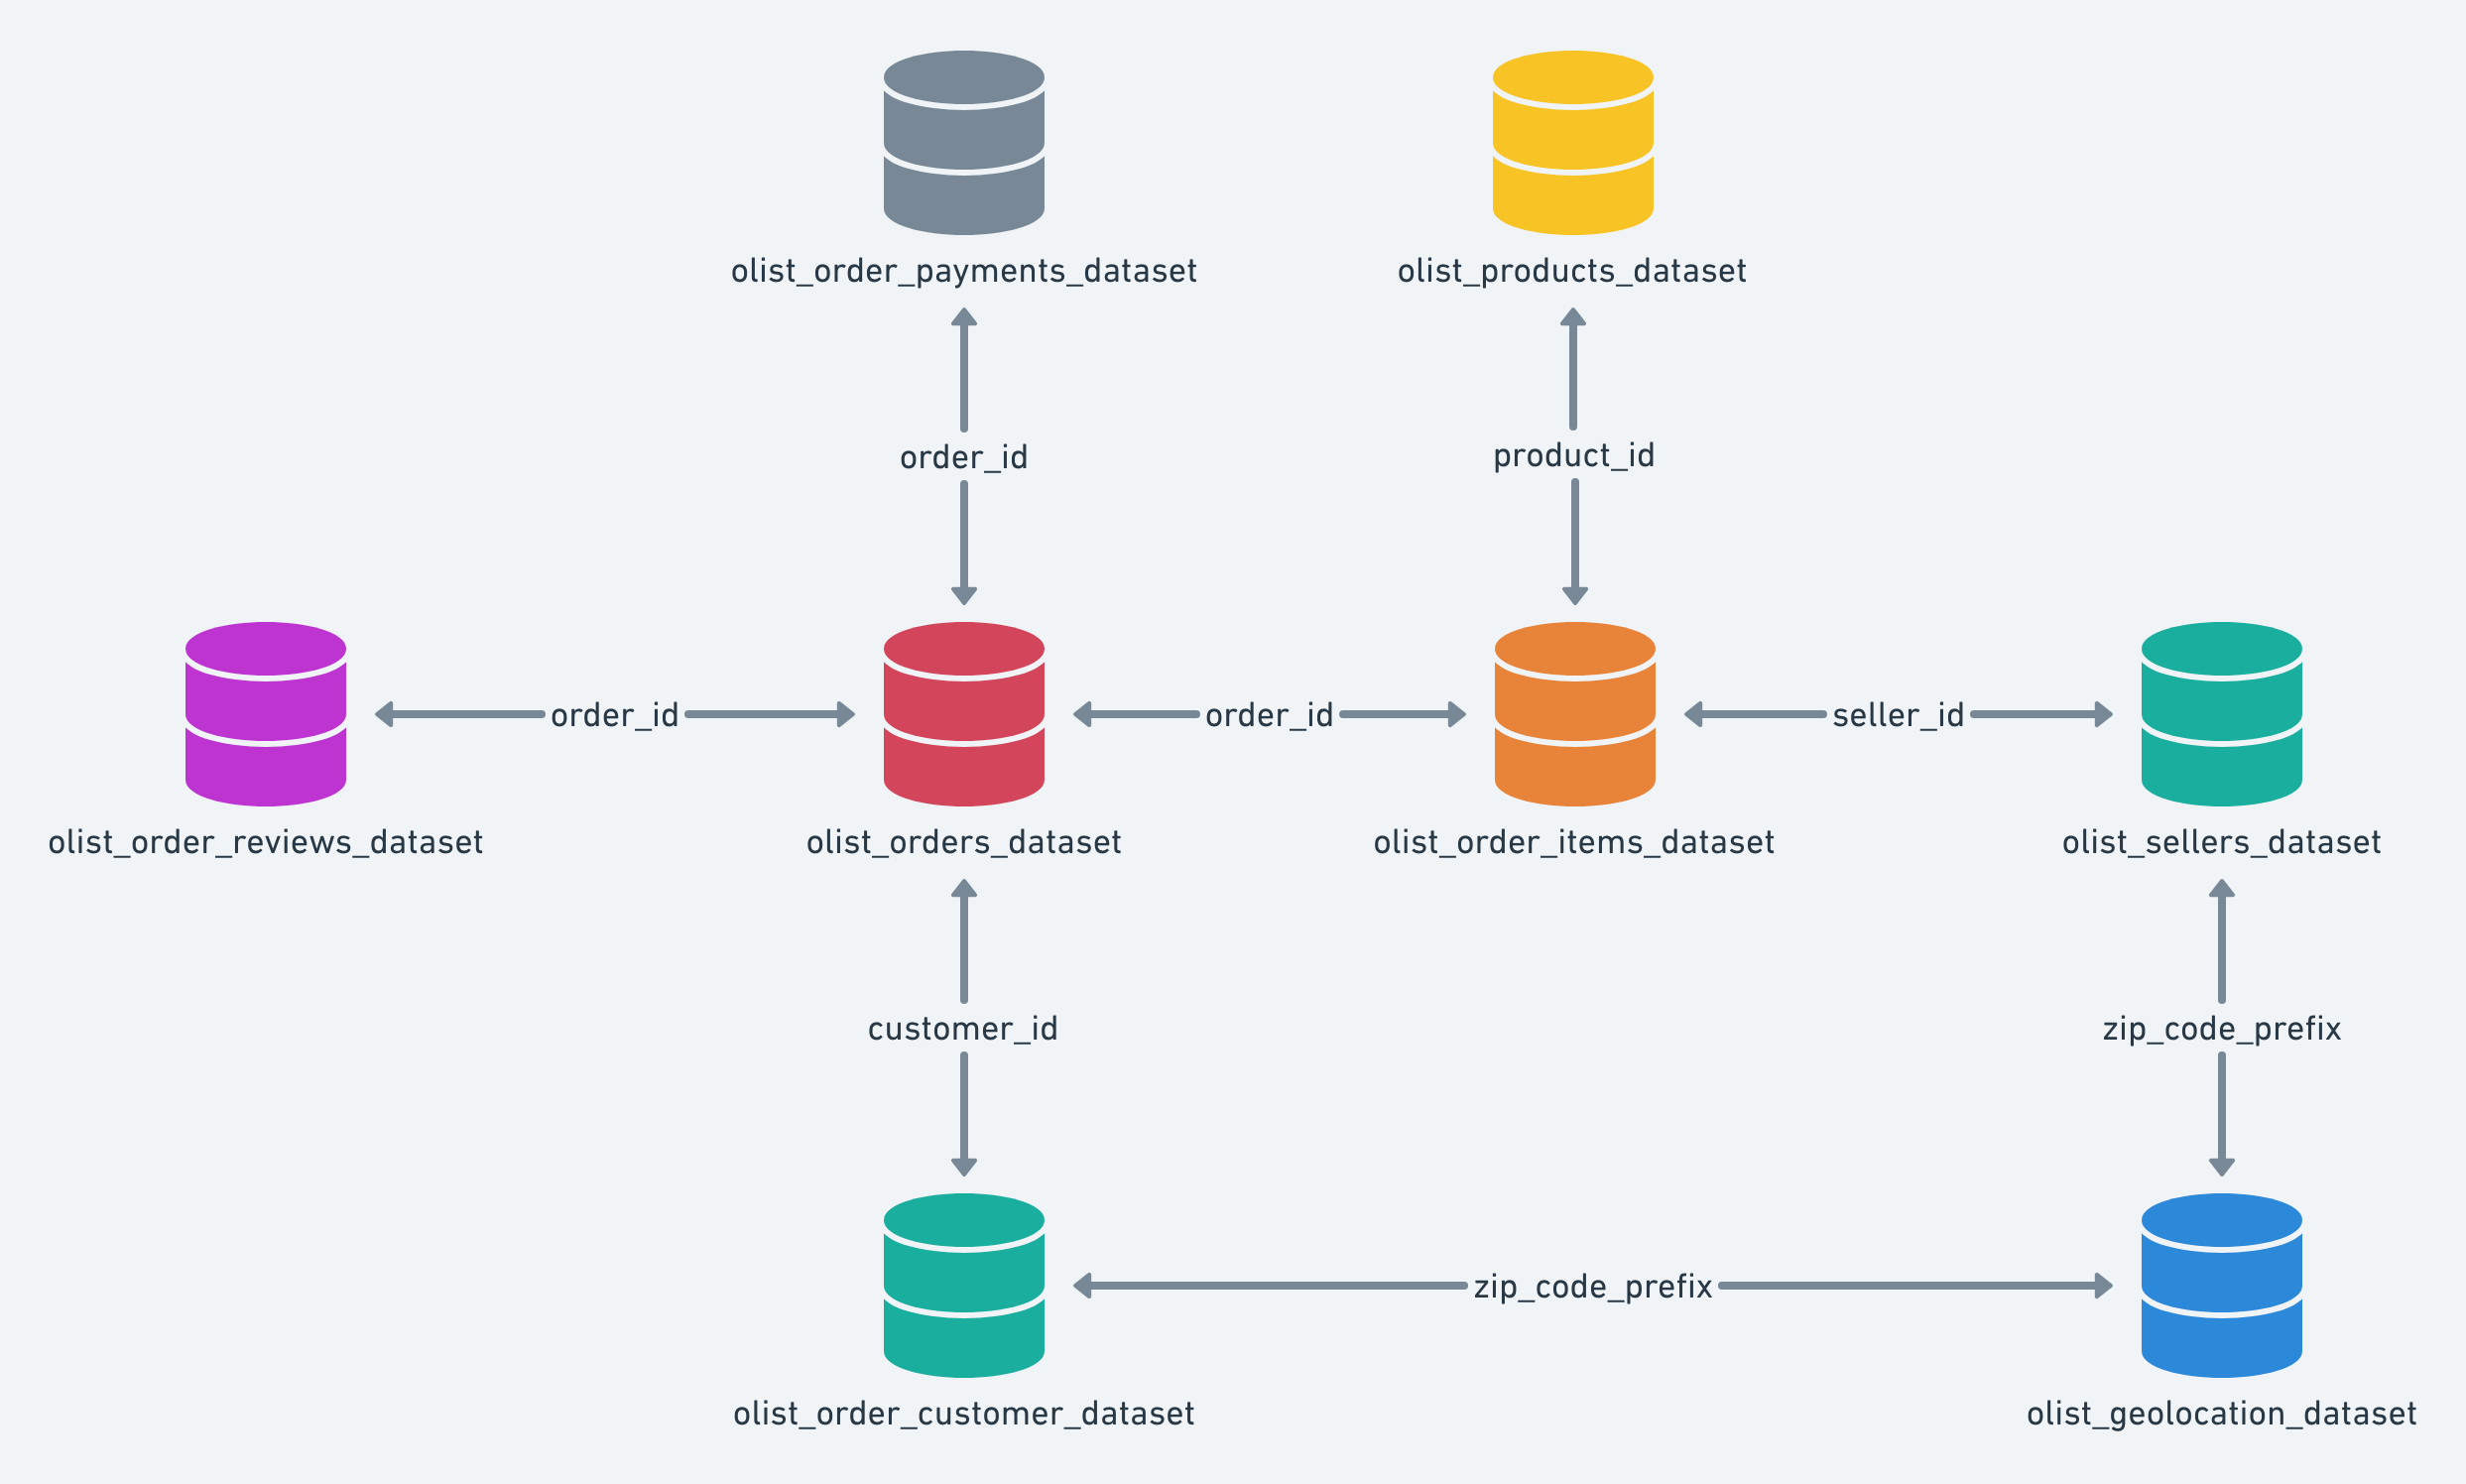

In [115]:
import os

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

from collections import Counter
import folium #open street map
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

## 0. Loading the data

In [ ]:
orders = pd.read_csv('Olist Data/olist_orders_dataset.csv')

customers = pd.read_csv('Olist Data/olist_customers_dataset.csv')

geolocation = pd.read_csv('Olist Data/olist_geolocation_dataset.csv')

order_items = pd.read_csv('Olist Data/olist_order_items_dataset.csv')

order_payments = pd.read_csv('Olist Data/olist_order_payments_dataset.csv')

order_reviews = pd.read_csv('Olist Data/olist_order_reviews_dataset.csv')

products = pd.read_csv('Olist Data/olist_products_dataset.csv')

sellers = pd.read_csv('Olist Data/olist_sellers_dataset.csv')

In [ ]:
print('Shape of orders dataset:', orders.shape)
# orders.sample(3)

print('Shape of customers dataset:', customers.shape)
# customers.sample(3)

print('Shape of geolocation dataset:', geolocation.shape)
# geolocation.sample(3)

print('Shape of order_items dataset:', order_items.shape)
# order_items.sample(3)

print('Shape of order_payments dataset:', order_payments.shape)
# order_payments.sample(3)

print('Shape of order_reviews dataset:', order_reviews.shape)
# order_reviews.sample(3)

print('Shape of products dataset:', products.shape)
# products.sample(3)

print('Shape of sellers dataset:', sellers.shape)
# sellers.sample(3)

Shape of orders dataset: (99441, 8)
Shape of customers dataset: (99441, 5)
Shape of geolocation dataset: (1000163, 5)
Shape of order_items dataset: (112650, 7)
Shape of order_payments dataset: (103886, 5)
Shape of order_reviews dataset: (100000, 7)
Shape of products dataset: (32951, 9)
Shape of sellers dataset: (3095, 4)


## 1. Data Preprocessing

### 1.1. Checking for duplicates

#### orders

In [ ]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [ ]:
# Checking for duplicate order_id 
orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,830189cecc91f11c9dd9405976aa5538,0766e8559ca223a62bed916c91eb8e36,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2017-06-19 18:47:51,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


* There are no duplicate orders_ids.

#### customers

In [ ]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [ ]:
# Checking for duplicate order_id
customers.customer_id.describe()

count                                99441
unique                               99441
top       17f0bf3ee55a47f1300daff51d479b1e
freq                                     1
Name: customer_id, dtype: object

* There are no duplicate customer_ids.

#### geolocation

In [ ]:
geolocation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [ ]:
print('Shape of geolocation dataset:', geolocation.shape)
print('Nubmer of unqiue values of geolocation_zip_code_prefix:', geolocation.geolocation_zip_code_prefix.nunique())

Shape of geolocation dataset: (1000163, 5)
Nubmer of unqiue values of geolocation_zip_code_prefix: 19015


* As per the given description and schema of the Olist dataset, *zip_code_prefix* is the primary key that links **geolocation** dataset to **sellers** and **customers** datasets.
* Ideally, the number of rows in the geolocation dataset should be equal to number of unique values of *zip_code_prefix*, which is not the case. <br>Therefore, there are potential duplicates in geolocations dataset.

Let's now see if there is any difference between multiple rows with same zip_code_prefix.

In [ ]:
geolocation.sort_values('geolocation_zip_code_prefix').head(10)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
1004,1001,-23.549292,-46.633559,sao paulo,SP
771,1001,-23.550498,-46.634338,sao paulo,SP
235,1001,-23.550642,-46.634410,sao paulo,SP
1062,1001,-23.550498,-46.634338,sao paulo,SP
897,1001,-23.549292,-46.633559,sao paulo,SP


* Form the above, it turns out that all rows are alomost same except for slight variations(of decimal points) in *geolocation_lat*(latitude) and *geolocation_lng*(longitude) columns.
This doens't make much sense and hence, in the next step, we would just keep one row for each zip_code_prefix and remove the rest.

In [ ]:
geolocation.drop_duplicates(subset='geolocation_zip_code_prefix', inplace=True)
print('Shape of geolocation dataset after removing duplicates:', geolocation.shape)

Shape of geolocation dataset after removing duplicates: (19015, 5)


#### order_items

In [ ]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [ ]:
order_items[order_items.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


* *order_id* in order_items dataset can repeat as there can be more than one items in a single order. Similarly product_id can repeat as same product can be present in multiple orders. Therefore, we just need to check if there are any duplicate rows in this dataset. Luckily, there are none.

#### order_payments

In [ ]:
order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [ ]:
order_payments[order_payments.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


* *order_id* can repeat as a customer may pay an order with more than one payment method.

#### order_reviews

In [ ]:
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [ ]:
order_reviews.order_id.describe()

count                               100000
unique                               99441
top       c88b1d1b157a9999ce368f218a407141
freq                                     3
Name: order_id, dtype: object

* Looks like some orders have more than 1 reviews. Let's see an example.

In [ ]:
order_reviews[order_reviews.order_id=='c88b1d1b157a9999ce368f218a407141']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1997,ffb8cff872a625632ac983eb1f88843c,c88b1d1b157a9999ce368f218a407141,3,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:41:07
83187,202b5f44d09cd3cfc0d6bd12f01b044c,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:40:22
90069,fb96ea2ef8cce1c888f4d45c8e22b793,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-21 00:00:00,2017-07-26 13:45:15


* For all the orders having multiple reviews, we can aggregate the review_scores into single value by taking an average of all the review scores.

In [ ]:
order_reviews = order_reviews.groupby(by='order_id', as_index=False).mean()

In [ ]:
order_reviews[order_reviews.order_id=='c88b1d1b157a9999ce368f218a407141']

,order_id,review_score
77922,c88b1d1b157a9999ce368f218a407141,4.333333


#### products

In [ ]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [ ]:
products.product_id.describe()

count                                32951
unique                               32951
top       3ead98d9c2d2523708d7c77be6fafcdf
freq                                     1
Name: product_id, dtype: object

* There are no duplicate product_ids.

#### sellers

In [ ]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [ ]:
sellers.seller_id.describe()

count                                 3095
unique                                3095
top       29fe9f200d3fa0c668d2aa1ec7e08dfb
freq                                     1
Name: seller_id, dtype: object

* There are no duplicate seller_ids.

### 1.2. Consolidating the data

#### Merging sellers and geolocation

In [ ]:
sellers_loc = sellers.merge(geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left', copy=False)
sellers_loc.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP


In [ ]:
sellers_loc.drop(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], axis=1, inplace=True)

In [ ]:
sellers_loc.rename(columns={'geolocation_lat':'seller_lat', 'geolocation_lng':'seller_lng'}, inplace=True)
sellers_loc.sample(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
1047,4b39558c138930b9e5489c93b6df5fe3,49055,aracaju,SE,-10.911449,-37.059697
2313,42ef3192a9ff87a22d1867b74b3ee205,9090,santo andre,SP,-23.651980,-46.540952


#### Merging customers and geolocation

In [ ]:
customers_loc = customers.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left', copy=False)
customers_loc.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.509897,-47.397866,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,9790.0,-23.726853,-46.545746,sao bernardo do campo,SP


In [ ]:
customers_loc.drop(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], axis=1, inplace=True)

In [ ]:
customers_loc.rename(columns={'geolocation_lat':'customer_lat', 'geolocation_lng':'customer_lng'}, inplace=True)
customers_loc.sample(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
73395,7bfdb3d0f53ea882f2a470c6ec01a983,2f6bfa6509c44c47a19d724930a66a29,8583,itaquaquecetuba,SP,-23.435673,-46.380328
98195,1251538e4e2d9de1c61999470342ed3c,52541f277de0476d40074256599f6714,3051,sao paulo,SP,-23.540112,-46.597187


#### Merging order_items, sellers and products

In [ ]:
items_sell = order_items.merge(sellers_loc, on='seller_id', how='left', copy=False)
items_sell.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,27277,volta redonda,SP,-22.498183,-44.123614
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,3471,sao paulo,SP,-23.566258,-46.518417


In [ ]:
items = items_sell.merge(products, on='product_id', how='left', copy=False)
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,27277,volta redonda,SP,-22.498183,-44.123614,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,3471,sao paulo,SP,-23.566258,-46.518417,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0


#### Final merge, consolidating everything into a single dataframe, **orders**

In [ ]:
orders_custom = orders.merge(customers_loc, on='customer_id', how='left', copy=False)
orders_custom.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.169860,-44.988369


In [ ]:
orders_custom_reviews = orders_custom.merge(order_reviews, on='order_id', how='left', copy=False)
orders_custom_reviews.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.169860,-44.988369,4.0


In [ ]:
orders_custom_reviews_pay = orders_custom_reviews.merge(order_payments, on='order_id', how='left', copy=False)
orders_custom_reviews_pay.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,4.0,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,4.0,3.0,voucher,1.0,2.00


In [ ]:
orders_final = orders_custom_reviews_pay.merge(items, on='order_id', how='left', copy=False)
orders_final.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,4.0,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350.0,maua,SP,-23.680114,-46.452454,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,4.0,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350.0,maua,SP,-23.680114,-46.452454,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,4.0,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350.0,maua,SP,-23.680114,-46.452454,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.169860,-44.988369,4.0,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,31570.0,belo horizonte,SP,-19.810119,-43.984727,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.746337,-48.514624,5.0,1.0,credit_card,3.0,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,14840.0,guariba,SP,-21.362358,-48.232976,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0


In [ ]:
orders_final.to_csv('/content/drive/My Drive/Colab Notebooks/Olist_orders_final.csv', index=False)

### 1.3. Handling Missing Values

In [117]:
orders = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Olist_orders_final.csv')

In [118]:
orders.shape

(118434, 38)

In [119]:
orders[orders.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,-27.855758,-54.447381,2.0,1.0,credit_card,1.0,65.95,1.0,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,2017-04-19 13:25:17,49.90,16.05,5455.0,sao paulo,SP,-23.536892,-46.713111,NaN,NaN,NaN,NaN,600.0,35.0,35.0,15.0
51,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP,-23.175897,-46.886594,1.0,1.0,boleto,1.0,22.36,1.0,c50ca07e9e4db9ea5011f06802c0aea0,e9779976487b77c6d4ac45f75ec7afe9,2018-06-13 04:30:33,14.49,7.87,11701.0,praia grande,SP,-24.011288,-46.418734,beleza_saude,59.0,1782.0,1.0,125.0,25.0,14.0,18.0
125,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00,c7f8d7b1fffc946d7069574f74c39f4e,88140,santo amaro da imperatriz,SC,-27.687231,-48.780649,3.0,1.0,boleto,1.0,50.35,1.0,1522589c64efd46731d3522568e5bc83,28405831a29823802aa22c084cfd0649,2018-08-13 06:15:14,35.00,15.35,3644.0,sao paulo,SP,-23.526115,-46.535078,artigos_de_natal,35.0,415.0,4.0,550.0,37.0,10.0,37.0
129,bfe42c22ecbf90bc9f35cf591270b6a7,803ac05904124294f8767894d6da532b,delivered,2018-01-27 22:04:34,2018-01-27 22:16:18,2018-02-03 03:56:00,2018-02-09 20:16:40,2018-02-26 00:00:00,34c58672601f2c6d29db7efd1f6bf958,38650,bonfinopolis de minas,MG,-16.564400,-45.981986,5.0,1.0,credit_card,1.0,42.40,1.0,71225f49be70df4297892f6a5fa62171,e5a3438891c0bfdb9394643f95273d8e,2018-01-31 22:16:18,27.30,15.10,13483.0,limeira,SP,-22.568350,-47.447439,NaN,NaN,NaN,NaN,200.0,16.0,2.0,11.0
155,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00,9f269af9c49244f6ba4a46985a3cfc2e,3436,sao paulo,SP,-23.558009,-46.534168,5.0,1.0,credit_card,2.0,138.28,1.0,61d52f4882421048afd530db53d6f230,fa74b2f3287d296e9fbd2cc80f2d1cf1,2017-09-20 14:30:09,125.90,12.38,19023.0,presidente prudente,SP,-22.115452,-51.396409,perfumaria,59.0,149.0,1.0,500.0,36.0,18.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118237,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP,-23.944502,-46.331243,5.0,1.0,voucher,1.0,63.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118286,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00,965191786b70912f793e4a777fd623cd,13050,campinas,SP,-22.932218,-47.096790,1.0,1.0,boleto,1.0,144.56,1.0,0a57f7d2c983bcf8188589a5fea4a8da,4342d4b2ba6b161468c63a7e7cfce593,2018-01-19 07:18:05,129.90,14.66,22793.0,rio de janeiro,RJ,-23.009271,-43.429409,relogios_presentes,33.0,932.0,1.0,396.0,18.0,11.0,14.0
118330,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,d05c44a138277ad325d91

In [120]:
print(f'Number of rows having NAs: {5592} ({100*5592/118434:.2f}% of dataset)')

Number of rows having NAs: 5592 (4.72% of dataset)


* Some pieces of information have not been provided in the dataset, which is indicated by NANs in the above dataframe.
* Since a very small subset(less than 5%) of the data has NAs, we can drop these rows and work on the remaining data (>95%).
* There are other more sophisticated methods to treat NAs. We have not considered them for the sake of simplicity.

In [121]:
orders.dropna(inplace=True)
orders.shape

(112842, 38)

In [122]:
orders[orders.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


### 1.4. Mapping product category names from Portuguese to English

In [123]:
# Creating a Portuguese to English mapping of product category names from the given csv file
category_map = pd.read_csv('Olist Data/product_category_name_translation.csv', index_col=0).to_dict('dict')['product_category_name_english']

In [124]:
# Some Samples
dict(list(category_map.items())[:10])

{'automotivo': 'auto',
 'beleza_saude': 'health_beauty',
 'cama_mesa_banho': 'bed_bath_table',
 'esporte_lazer': 'sports_leisure',
 'informatica_acessorios': 'computers_accessories',
 'moveis_decoracao': 'furniture_decor',
 'perfumaria': 'perfumery',
 'relogios_presentes': 'watches_gifts',
 'telefonia': 'telephony',
 'utilidades_domesticas': 'housewares'}

**First, let us check if mapping is available for all the product category names**

In [125]:
set(orders['product_category_name']) - set(category_map.keys())

{'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

*'pc_gamer'* **and** *'portateis_cozinha_e_preparadores_de_alimentos'* **are not present in our dictionary. We will add these manually.** 

In [126]:
category_map['pc_gamer'] = 'pc_games'
category_map['portateis_cozinha_e_preparadores_de_alimentos'] = 'portable_kitchen_and_food_preparers'

In [127]:
# Applying the mapping in orders dataframe
orders['product_category'] = orders['product_category_name'].map(category_map)

In [128]:
# Check if there are NAs left over
orders[orders.isna().any(axis=1)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category


## 2. Exploratory Data Analysis

In [129]:
orders.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
56798,fb1b43869922a4c4faadf387772149ed,c44b6bba86baedddb69239d21d30e9b1,delivered,2018-07-06 11:50:08,2018-07-06 12:11:05,2018-07-10 15:54:00,2018-07-14 15:32:40,2018-08-08 00:00:00,6c4f592c07af0871a867590961915e1c,5727,sao paulo,SP,-23.625590,-46.739051,5.0,1.0,credit_card,2.0,138.11,1.0,4298b7e67dc399c200662b569563a2b2,88460e8ebdecbfecb5f9601833981930,2018-07-18 12:11:05,123.90,14.21,87030.0,maringa,PR,-23.418486,-51.926259,informatica_acessorios,58.0,420.0,1.0,200.0,21.0,14.0,15.0,computers_accessories
19913,18bfd88cce0908a86624e1fe45693ab5,b7fadbed2cafaf71c41450cb2ebe7013,delivered,2018-04-18 09:13:46,2018-04-18 09:30:37,2018-04-19 23:02:31,2018-05-04 00:22:55,2018-05-16 00:00:00,e5a3da4ea9055b0fdf99e847b1c34dc5,41680,salvador,BA,-12.951850,-38.402630,4.0,1.0,credit_card,10.0,149.59,1.0,f6c8384f424cad1a22fd89bbc62ff7ae,f789d2c4f2c2eb38fc4373e7a4b35264,2018-04-24 09:30:36,129.99,19.60,36010.0,juiz de fora,MG,-21.762825,-43.342956,pet_shop,60.0,479.0,3.0,300.0,27.0,9.0,27.0,pet_shop
65124,7b511d9d317e777fb4552fa4c7dc717e,f08b3962307cba722fa392226a16c26b,delivered,2017-07-10 12:23:45,2017-07-10 12:43:45,2017-07-10 17:05:13,2017-07-21 16:43:37,2017-08-11 00:00:00,ca6a4a0765e19a5263bb2742d1035715,66053,belem,PA,-1.448712,-48.489229,4.0,1.0,credit_card,1.0,159.51,1.0,6f33a4a09ae1180a0ee1ff4682b2d21f,725c32fa80c2faacc4fc88450d27314e,2017-07-14 12:43:45,139.99,19.52,3320.0,sao paulo,SP,-23.547286,-46.569409,brinquedos,49.0,426.0,7.0,700.0,44.0,12.0,22.0,toys
32954,f1b7c83171b22e2babd61eb8501d58d5,aa1a31f8a0300300ec81904ca291c40f,delivered,2018-02-24 15:34:01,2018-02-24 15:50:23,2018-02-26 22:08:39,2018-02-28 13:50:03,2018-03-15 00:00:00,d0e91e617fcb0f9cb5312eb984e30a20,13455,santa barbara d'oeste,SP,-22.725554,-47.366558,5.0,1.0,credit_card,2.0,44.27,1.0,34aec6c5358dee4e71cbaefc14935c5e,4e922959ae960d389249c378d1c939f5,2018-03-06 15:50:23,36.00,8.27,12327.0,jacarei,SP,-23.298186,-45.974828,beleza_saude,60.0,733.0,1.0,150.0,20.0,10.0,20.0,health_beauty
29064,a16c1e5c3c877e414d0e584e18ccb860,02ee17ed5705b0015ca334b76b8373e5,delivered,2018-04-18 00:21:36,2018-04-18 00:33:28,2018-04-18 23:22:18,2018-05-03 22:08:44,2018-05-21 00:00:00,8b1962e2787ecd68e878db50de992905,75660,buriti alegre,GO,-18.133385,-49.043256,5.0,1.0,credit_card,2.0,48.22,1.0,c9c6fde711572c1ad99ca12728c6af00,562fc2f2c2863ab7e79a9e4388a58a14,2018-04-24 00:30:58,29.99,18.23,13070.0,campinas,SP,-22.895876,-47.079185,telefonia,51.0,678.0,2.0,150.0,17.0,8.0,14.0,telephony


### 2.1. Orders by customer location

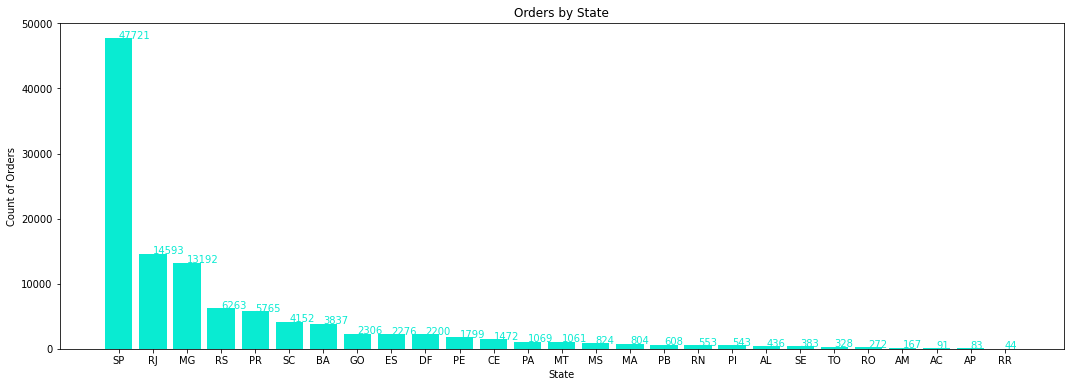

In [130]:
c = np.random.rand(3,) #randomly select RGB values plot color
state_count = Counter(list(orders.customer_state))
x, y = zip(*state_count.most_common())
plt.figure(figsize=[18,6])
plt.bar(x, y, color=c)
for i, val in enumerate(y):
    plt.annotate(val, (x[i], y[i]), color=c)
plt.xlabel('State')
plt.ylabel('Count of Orders')
plt.title('Orders by State')
plt.grid(False, axis='x')
plt.show()

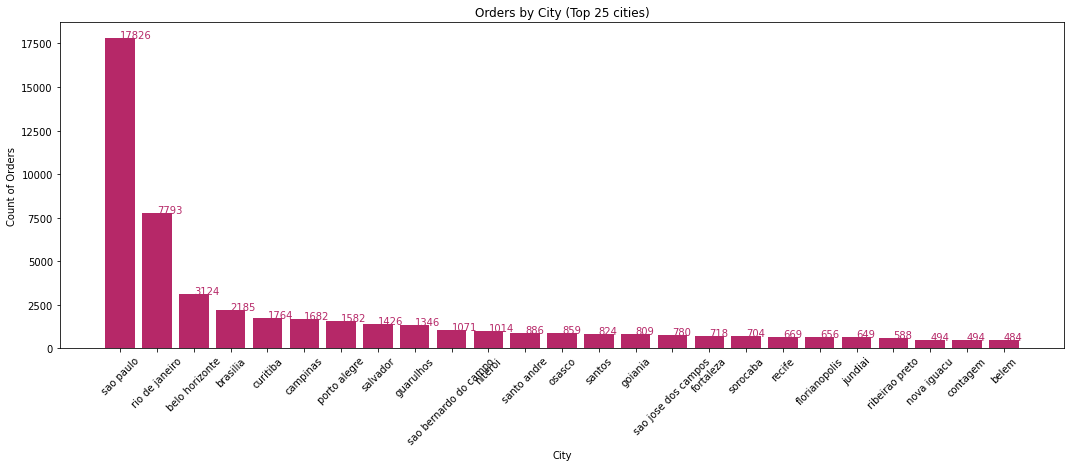

In [132]:
c = np.random.rand(3,) #randomly select RGB values plot color
city_count = Counter(list(orders.customer_city))
x, y = zip(*city_count.most_common(25))
plt.figure(figsize=[18,6])
plt.bar(x, y, color=c)
for i, val in enumerate(y):
    plt.annotate(val, (x[i], y[i]), color=c)
plt.xlabel('City')
plt.ylabel('Count of Orders')
plt.title('Orders by City (Top 25 cities)')
plt.xticks(rotation=45)
plt.grid(False, axis='x')
plt.show()

In [140]:
# Plotting Customers locations
map_osm = folium.Map(location=[-14.235, -51.9253], tiles='Stamen Toner', max_zoom=4)
# we will plot only 1000 random samples on the map, plotting all the dataset will take more time
sample_locations = orders.sample(1000)
for i,j in sample_locations.iterrows():
    if int(j['customer_lat']) != 0:
        folium.Marker(list((j['customer_lat'],j['customer_lng']))).add_to(map_osm)
map_osm

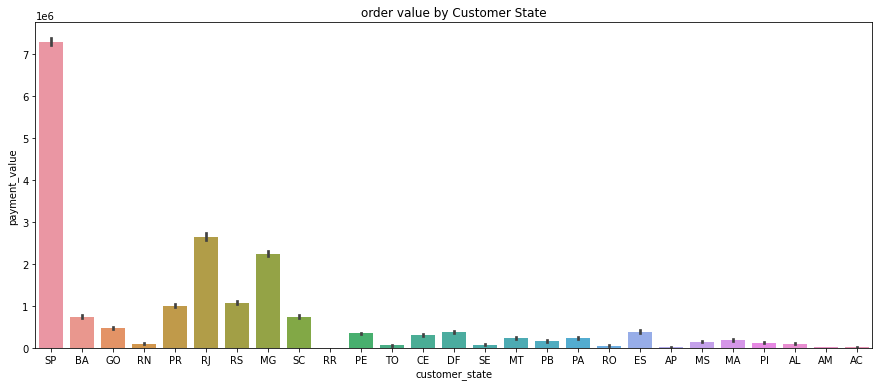

In [373]:
plt.figure(figsize=[15,6])
sns.barplot(x='customer_state', y='payment_value', data=orders, estimator=np.sum)
plt.title('order value by Customer State')
plt.show()

* Most of the orders come from Southeast Brazil. This is because most of the metropolitan areas having large population are located near the East and South borders of Brazil.
* The highest number of orders come from the state Sao Paulo(SP) followed by Rio de Janeiro(RJ) and Minas Gerais(MG). **These three states account for more than two thirds (66.9%) of the orders.**
* The cities that account for the highest number of orders are Sao Paulo(15.80%), Rio de Janeiro(6.91%) and Belo Horizonte(2.77%). This is quite logical as these are the capital cities of the above mentioned states.

### 2.2. Orders by seller location

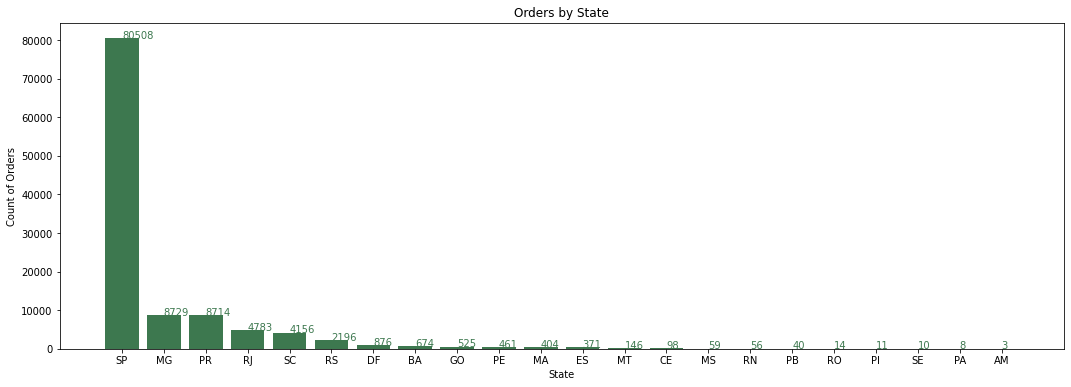

In [144]:
c = np.random.rand(3,) #randomly select RGB values plot color
state_count = Counter(list(orders.seller_state))
x, y = zip(*state_count.most_common())
plt.figure(figsize=[18,6])
plt.bar(x, y, color=c)
for i, val in enumerate(y):
    plt.annotate(val, (x[i], y[i]), color=c)
plt.xlabel('State')
plt.ylabel('Count of Orders')
plt.title('Orders by State')
plt.grid(False, axis='x')
plt.show()

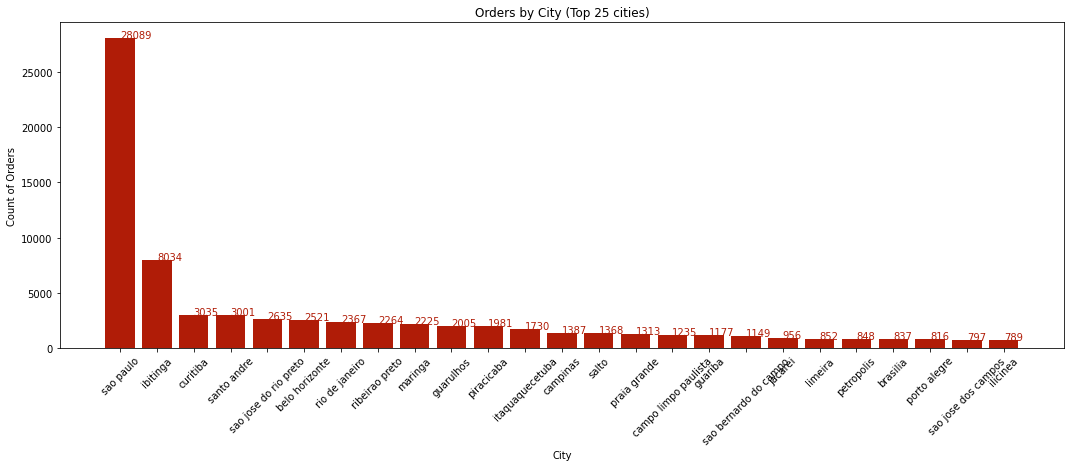

In [145]:
c = np.random.rand(3,) #randomly select RGB values plot color
city_count = Counter(list(orders.seller_city))
x, y = zip(*city_count.most_common(25))
plt.figure(figsize=[18,6])
plt.bar(x, y, color=c)
for i, val in enumerate(y):
    plt.annotate(val, (x[i], y[i]), color=c)
plt.xlabel('City')
plt.ylabel('Count of Orders')
plt.title('Orders by City (Top 25 cities)')
plt.xticks(rotation=45)
plt.grid(False, axis='x')
plt.show()

In [146]:
# Plotting sellers locations
map_osm = folium.Map(location=[-14.235, -51.9253], tiles='Stamen Toner',  max_zoom=4)
# we will plot only 1000 random samples on the map, plotting all the dataset will take more time
sample_locations = orders.sample(1000)
for i,j in sample_locations.iterrows():
    if int(j['seller_lat']) != 0:
        folium.Marker(list((j['seller_lat'],j['seller_lng']))).add_to(map_osm)
map_osm

* Most of the sellers are located in Southeast Brazil.
* The highest number of orders are catered by the sellers located in the state of Sao Paulo(SP) followed by Minas Gerais(MG) and Parana(PR). **Sao Paulo alone is harbour to sellers that cater almost three fourth (71.34% of the orders.**
* The cities that harbour sellers serving the highest number of orders are Sao Paulo(24.89%), and  Ibitinga(7.12%). 

### 2.3. Orders by product Category

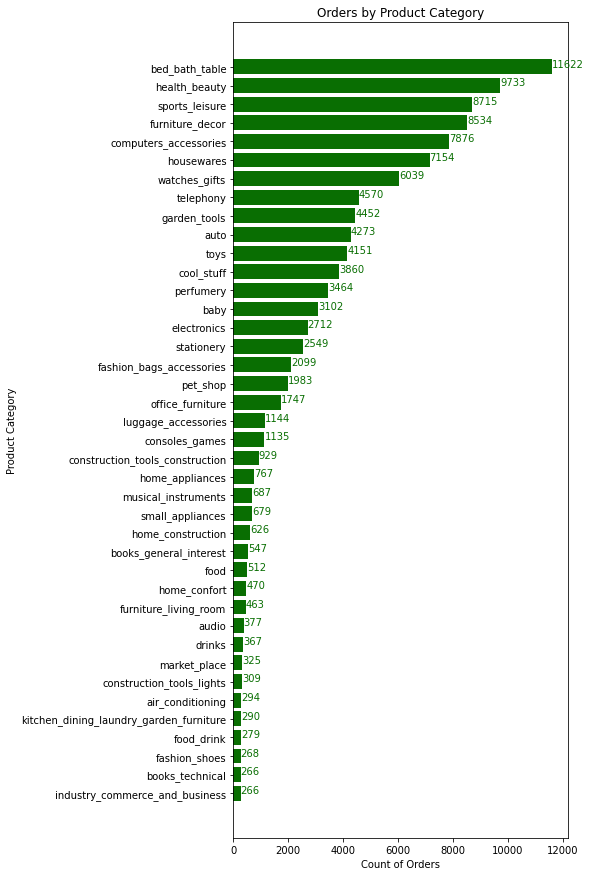

In [228]:
import plotly.express as px

c = np.random.rand(3,) #randomly select RGB values plot color
cat_count = Counter(list(orders.product_category))
x, y = zip(*cat_count.most_common(40))
plt.figure(figsize=[6,15])
plt.barh(x, y, color=c)
for i, val in enumerate(y):
    plt.annotate(val, (y[i], x[i]), color=c)

plt.gca().invert_yaxis()
plt.xlabel('Count of Orders')
plt.ylabel('Product Category')
plt.title('Orders by Product Category')
plt.grid(False, axis='y')
plt.show()


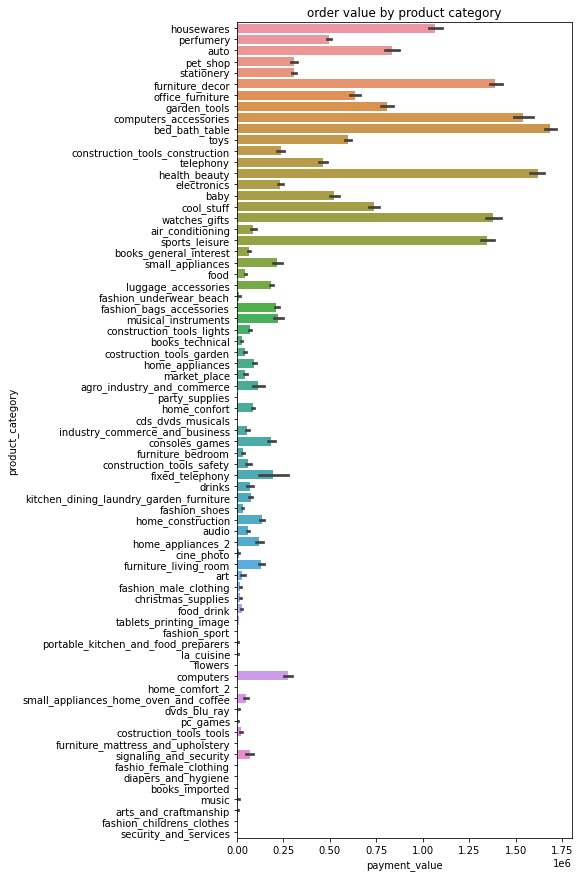

In [216]:
plt.figure(figsize=[6,15])
sns.barplot(y='product_category', x='payment_value', data=orders, estimator=np.sum)
plt.title('order value by product category')
plt.show()

* Categories such as *'bed_bath_table', 'health_beauty', 'sports_leisure', 'furniture_decor', 'computers_accessories', 'housewares'*, etc. have very high number of orders. On the other hand, *'pc_games', 'fashion_childrens_clothes', 'security_and_services'* hardly have any orders.
* Categories *'bed_bath_table', 'health_beauty', 'computers_accessories', 'furniture_decor',  'sports_leisure', 'watch_gifts'* account for the highest sales value(money).

### 2.4. Orders payment methods

In [230]:
counts = orders.payment_type.value_counts()

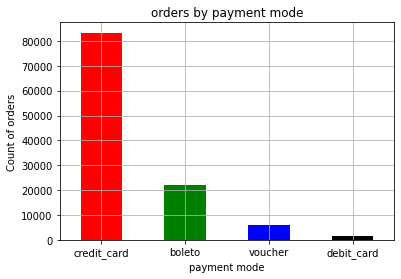

Number of orders paid by credit_card : 83277 ( 73.8 %)
Number of orders paid by boleto : 21952 ( 19.454 %)
Number of orders paid by voucher : 5992 ( 5.31 %)
Number of orders paid by debit_card : 1621 ( 1.437 %)


In [233]:
my_colors = list('rgbkymc')
counts.plot(kind='bar', color=my_colors, rot=0)
plt.xlabel('payment mode')
plt.ylabel('Count of orders')
plt.title('orders by payment mode')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_counts = np.argsort(-counts.values)
for i in sorted_counts:
    print('Number of orders paid by', counts.index[i], ':',counts.values[i], '(', np.round((counts.values[i]/orders.shape[0]*100), 3), '%)')

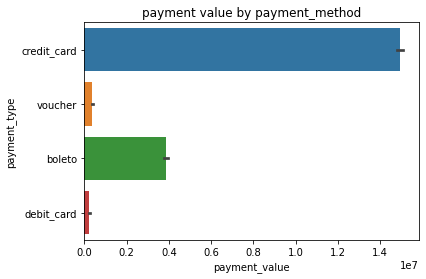

In [245]:
sns.barplot(y='payment_type', x='payment_value', data=orders, estimator=np.sum)
plt.title('payment value by payment_method')
plt.show()

### 2.5. Orders reviews

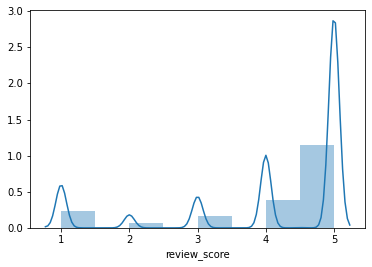

In [249]:
sns.distplot(orders.review_score, bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.show()

* Most of the orders have very high review scores

### 2.6. Product Name and Description length

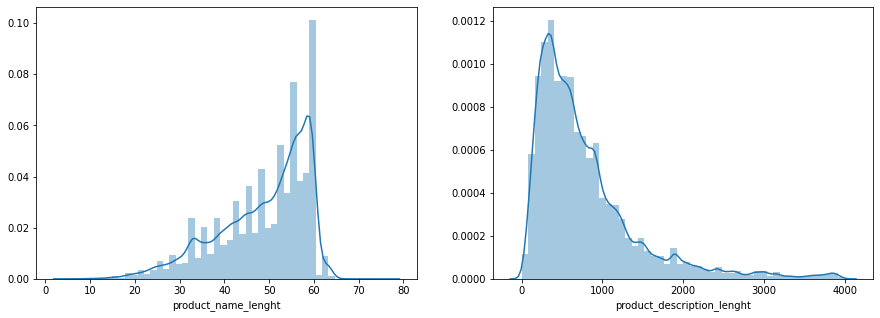

In [254]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(orders.product_name_lenght)
plt.subplot(1,2,2)
sns.distplot(orders.product_description_lenght)
plt.show()

* Products with fairly long names have higher number of orders.
* Products whose description is shorter are more likely to be ordered.

### 2.7. Product photos qty

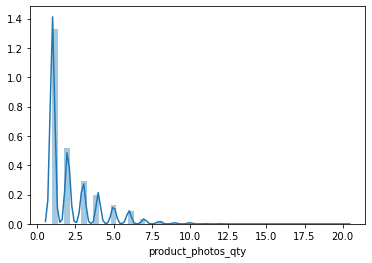

In [257]:
sns.distplot(orders.product_photos_qty)
plt.show()

* Most of the products ordered have less than 5 photos.

### 2.8. Distance between Seller and Customer

In [352]:
distance = []
for index, row in tqdm(orders.iterrows()):
    seller = [radians(row['seller_lat']), radians(row['seller_lng'])]
    customer = [radians(row['customer_lat']), radians(row['customer_lng'])]
    distance.append((haversine_distances([seller, customer])* 3956)[1][0])


In [354]:
orders['customer_distance'] = distance

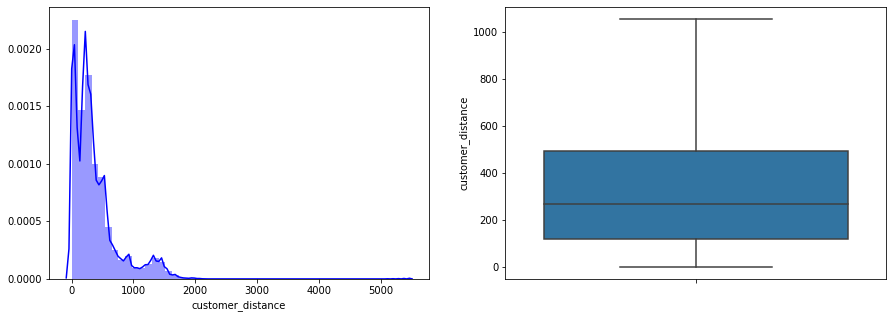

In [371]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(orders.customer_distance, color='b')
plt.subplot(1,2,2)
sns.boxplot(orders.customer_distance, orient='v', showfliers=False)
plt.show()

* The distance between the seller and the customer is less than 1000 miles for most of the orders. We might want to recall our earlier observation that most of the seller and customers are located in Southeast Brazil.

### 2.9. Daily trend in number of orders placed

In [265]:
# first 10 characters of the purchase time stamp will give us order date
orders['purchase_date'] = pd.to_datetime(orders['order_purchase_timestamp'].apply(lambda x : x[:10]))

In [313]:
df = orders.sort_values(by='purchase_date').groupby('purchase_date', as_index=False).count()

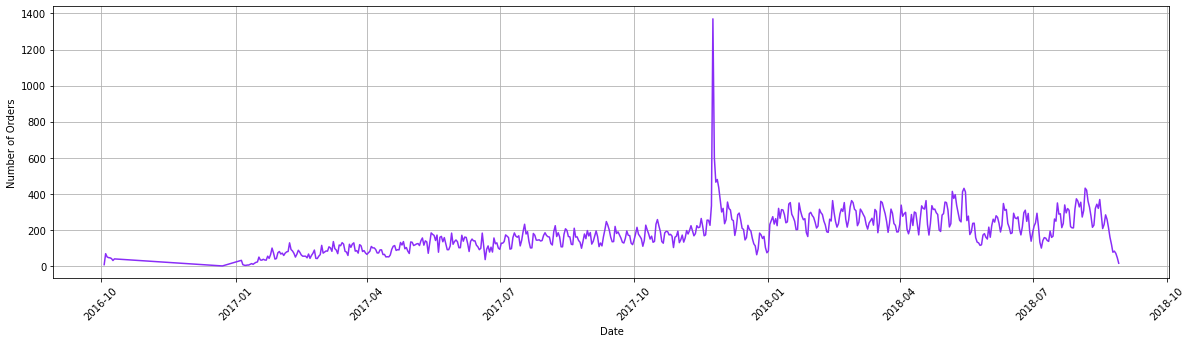

In [322]:
c=np.random.rand(3)
plt.figure(figsize=(20,5))
plt.plot(df.purchase_date, df.order_id, color=c)
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid()
plt.show()

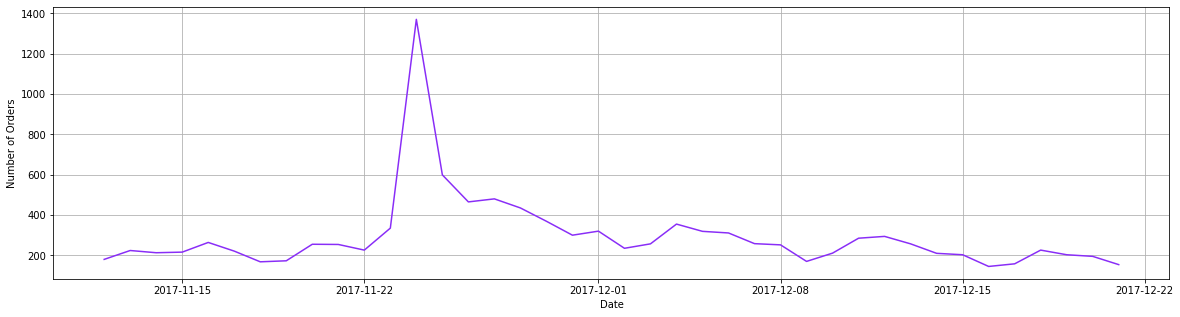

In [323]:
#zooming in around peak
plt.figure(figsize=(20,5))
plt.plot(df.purchase_date[320:360], df.order_id[320:360], color=c)
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

* There's an overall increasing trend in the number of orders with time.
* Number of orders have suddenly peaked during last week of November 2017. This might be because of the upcoming festive season(People tend to shop more before festivals) 

### 2.10. Daily trend in total value of orders placed

In [295]:
df = orders.sort_values(by='purchase_date').groupby('purchase_date', as_index=False).sum()

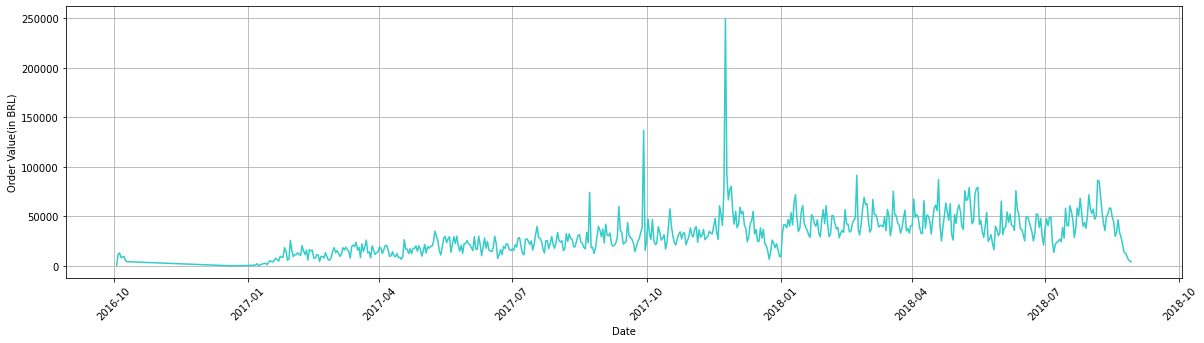

In [310]:
c=np.random.rand(3,)
plt.figure(figsize=(20,5))
plt.plot(df.purchase_date, df.payment_value, color=c)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Order Value(in BRL)')
plt.grid()
plt.show()

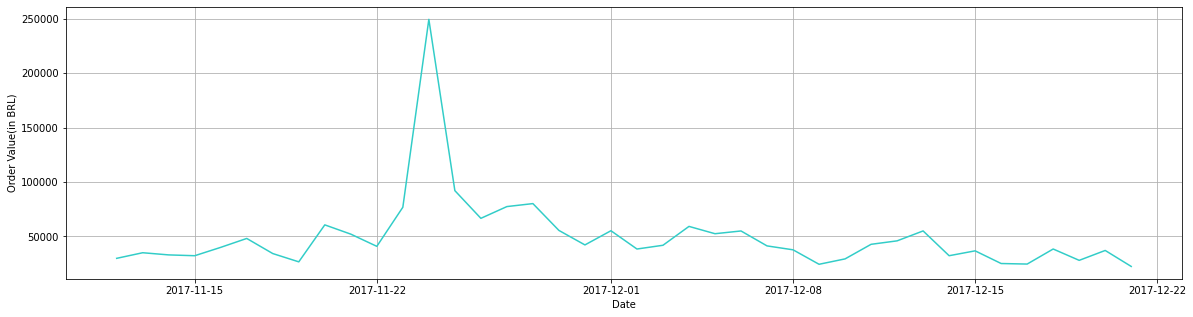

In [311]:
#zooming in around peak
plt.figure(figsize=(20,5))
plt.plot(df.purchase_date[320:360], df.payment_value[320:360], color=c)
plt.xlabel('Date')
plt.ylabel('Order Value(in BRL)')
plt.grid()
plt.show()

* Daily trends in Total Order Value are same as those in number of orders.